# 1) Setup

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import math
import scipy as sp
from scipy import stats

from copy import copy
import time
import yaml
import networkx as nx

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pymongo
from pymongo import MongoClient
from datetime import datetime
from datetime import timedelta
print("done")

done


In [24]:
#import functions from python files

#1) data import & filtering
from get_data import *
from get_data_yaml import *
from get_adjacent import *
from get_context import *

from filter_data1 import *
from filter_data2 import *
from filter_data3 import *
from filter_data4 import *
from filter_data5 import *

from select_data import *
from select_data_edge import *

from underscore_prefix import *
from underscore_suffix import *

from randomise_df import *


#2) Clustering edges
from ks_between_edges import *
from distances_ks import *
from distances_length import *
from distances_connections import *
from distances_connections2 import *

from augment_with_context import *

from draw_graph import *
from draw_clusters import *
from draw_count import *

from optimum_clusters import *


#4) Bayesian optimisation of Lognormal model
from Gamma import *
from Lognormal import *
from Gaussian import *
from Gaussian_broadcast import *
from Normal_Gamma import *

from Normal_Gamma_bayes import *
from Normal_Gamma_bayes_update import *
from Gaussian_ml import *              # for comparison


#5) Measures of error
from integrate_pdf import *
from integrate import *
from integrate_trapezium import *
from integrate_simpson import *

from error_crps import *
from error_crps_single import *
from error_ks import *
from error_ks_2samples import *
from error_cvm import *

from error_abs import *
from error_square import *


print("done")

done


In [3]:
#Retreive data
blenheim_scalar_random_df = pd.read_excel("blenheim_scalar_random.xlsx")
blenheim_scalar_random_df = blenheim_scalar_random_df.loc[:,["origin", "target", "edge_id", "operation_time", "n_robots"]]

blenheim_scalar_targeted_df = pd.read_excel("blenheim_scalar_targeted.xlsx")
blenheim_scalar_targeted_df = blenheim_scalar_targeted_df.loc[:,["origin", "target", "edge_id", "operation_time", "n_robots"]]

blenheim_scalar_combined_df = pd.read_excel("blenheim_scalar_combined.xlsx")
blenheim_scalar_combined_df = blenheim_scalar_combined_df.loc[:,["origin", "target", "edge_id", "operation_time", "n_robots"]]
print("done")

done


# 2) Blenheim clustering
- Based on spatial features

## 2a) Edge length

Time taken: 0.07480001449584961 secs
Time taken:  0.011969566345214844 secs
Optimum no. of clusters: 11
Max silhouette coeff: 0.9999999437551995


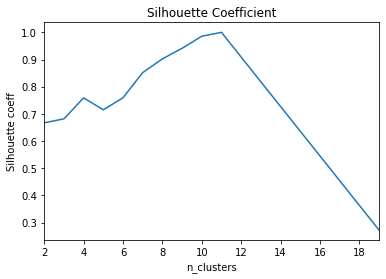

In [9]:
#Create matrix of edge_length distances
context = get_context("blenheim_map.yaml")
length_matrix, length_edges = distances_length(context)
n_clusters, s_list = optimum_clusters(length_matrix, max_clusters = 20, method = "ss")

[ 8  7  9 10  5  3  9  6  4  7  6  5  8  2  1  0  2 10  1  3  4  0]
11 clusters
no. of edges: 22
CLuster 0 has colour code: r
CLuster 1 has colour code: g
Edges without enough data are black


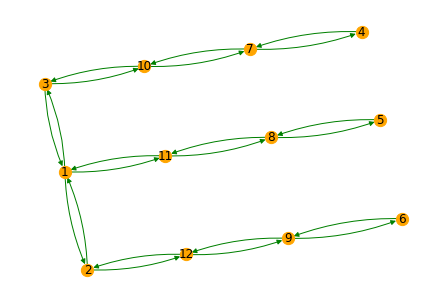

In [14]:
#for edge_length difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( length_matrix )
print(labels)
labels = np.zeros(len(length_edges)) + 1 
length_clusters = pd.DataFrame(index = np.arange(len(length_edges)),columns = ["edge_id", "cluster_id"])
length_clusters["edge_id"] = length_edges
length_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

G = draw_clusters("blenheim_map.yaml", length_clusters)
plt.savefig("clusters_length_blenheim.svg")

## 2b) Connections

Time taken: 0.0773017406463623 secs
Time taken:  0.01196742057800293 secs
Optimum no. of clusters: 3
Max silhouette coeff: 1.0


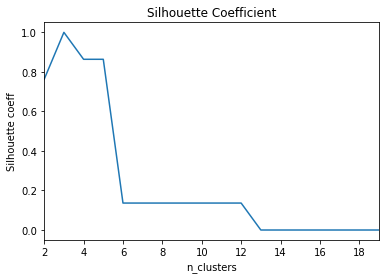

In [19]:
#Create matrix of connections_diff distances
context = get_context("blenheim_map.yaml")
connections_matrix, connections_edges = distances_connections2(context)
n_clusters, s_list = optimum_clusters(connections_matrix, max_clusters = 20, method = "ss")

[1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 0 1 0 1 1 0]
3 clusters
no. of edges: 22
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
Edges without enough data are black


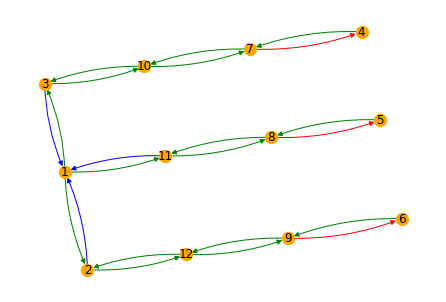

In [20]:
#for connections difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( connections_matrix )
print(labels)
connections_clusters = pd.DataFrame(index = np.arange(len(connections_edges)),columns = ["edge_id", "cluster_id"])
connections_clusters["edge_id"] = connections_edges
connections_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

G = draw_clusters("blenheim_map.yaml", connections_clusters)
plt.savefig("clusters_connections_blenheim.svg")

# 3) Blenheim clustering (combined)
- accounting for congestion

In [24]:
#separate by congestion level
congestion_1 = blenheim_scalar_combined_df[ blenheim_scalar_combined_df["n_robots"] == 1 ]
congestion_2 = blenheim_scalar_combined_df[ blenheim_scalar_combined_df["n_robots"] == 2 ]
congestion_3 = blenheim_scalar_combined_df[ blenheim_scalar_combined_df["n_robots"] == 3 ]
congestion_4 = blenheim_scalar_combined_df[ blenheim_scalar_combined_df["n_robots"] == 4 ]
congestion_5 = blenheim_scalar_combined_df[ blenheim_scalar_combined_df["n_robots"] == 5 ]
print(len(congestion_1),len(congestion_2),len(congestion_3),len(congestion_4),len(congestion_5))

12995 7818 1924 216 9


## 3a) 1 robot
- 1 cluster

Time taken: 3.126455068588257 secs
Optimum no. of clusters: 2
Max silhouette coeff: 0.5260563041081421


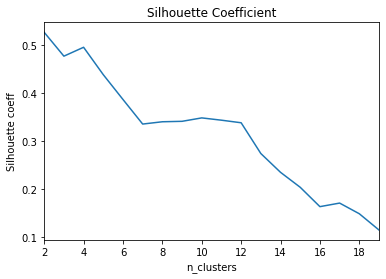

In [32]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_1)

#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 20, method = "ss")

## 3b) 2 robots
- 1 cluster

Time taken: 2.314755439758301 secs
Optimum no. of clusters: 2
Max silhouette coeff: 0.7080683593742513


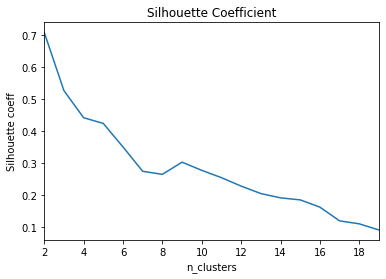

In [31]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_2)

#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 20, method = "ss")

## 3c) 3 robots
- 1 cluster

Time taken: 0.8204483985900879 secs
Optimum no. of clusters: 2
Max silhouette coeff: 0.7889381615812662


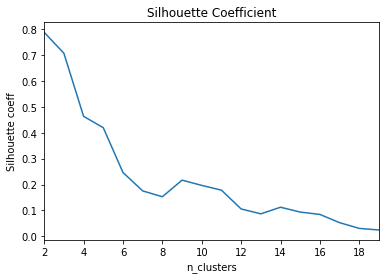

In [30]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_3)

#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 20, method = "ss")

## 3d) 4 robots
- 1 cluster

Time taken: 0.25969934463500977 secs
Optimum no. of clusters: 3
Max silhouette coeff: 0.40719440742438323


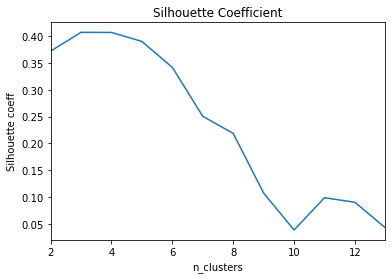

In [35]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_4)

#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 14, method = "ss")

Optimum no. of clusters: 12
Min CH index: 32.42240741000106


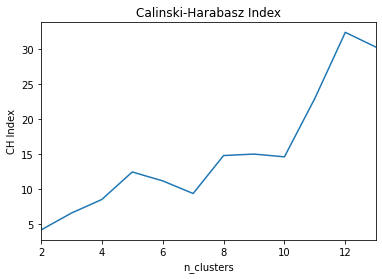

In [36]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 14, method = "ch")

Optimum no. of clusters: 13
Max DB index: 0.18385841280136314


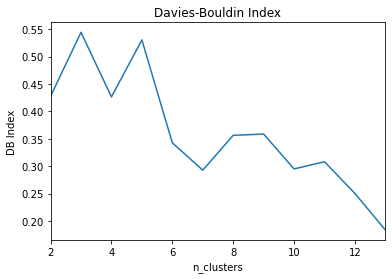

In [37]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 14, method = "db")

# 4) CVM & KS functions

In [4]:
# Select data of interest
wp1 = "WayPoint1"
wp2 = "WayPoint2"
edge1 = wp1 + "_" + wp2
subset1 = select_data_edge(blenheim_scalar_combined_df, edge1)
#independent variable to plot over
t_op1 = subset1["operation_time"]

wp1 = "WayPoint1"
wp2 = "WayPoint3"
edge2 = wp1 + "_" + wp2
subset2 = select_data_edge(blenheim_scalar_combined_df, edge2)
#independent variable to plot over
t_op2 = subset2["operation_time"]

#fit model 1

#use offset and take log of data
offset1= np.min(t_op1) - 0.01
t_log = np.log(t_op1 - offset1)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test1, var_test1, posterior1, mean_map1, var_map1 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b, plot_graph = False)
toc = time.time()
print("MAP mean:", mean_map1, "    MAP var:", var_map1)
print("Time for calculation:", toc-tic, "secs")


#fit model 2

#use offset and take log of data
offset2= np.min(t_op2) - 0.01
t_log = np.log(t_op2 - offset2)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test2, var_test2, posterior2, mean_map2, var_map2 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b, plot_graph = False)
toc = time.time()
print("MAP mean:", mean_map2, "    MAP var:", var_map2)
print("Time for calculation:", toc-tic, "secs")

MAP mean: 0.91     MAP var: 0.43
Time for calculation: 0.8164181709289551 secs
MAP mean: 0.8400000000000001     MAP var: 0.28
Time for calculation: 0.43739795684814453 secs


Text(0.5, 1.0, 'WayPoint1_WayPoint2')

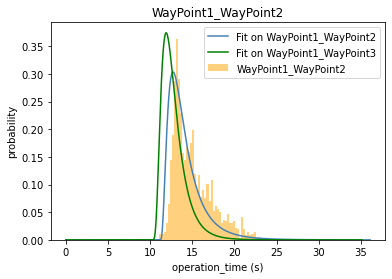

In [5]:
#Plot against actual data

precision = 2
t_start= 10**(-precision)
t_stop = ( (np.max(t_op1)) //5)*5 + 5    #round up to nearest 5 secs
t_step = 10**(-precision)
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes1 = Lognormal(t_test,mean_map1,var_map1)
p_bayes2 = Lognormal(t_test,mean_map2,var_map2)

#account for offset
t_offset1 = np.arange(t_stop, t_stop+offset1, t_step)
p_offset1 = np.zeros(len(t_offset1))
p_bayes1 = np.array([*p_offset1, *p_bayes1])
t_test1 = np.array([*t_test, *t_offset1])

t_offset2 = np.arange(t_stop, t_stop+offset2, t_step)
p_offset2 = np.zeros(len(t_offset2))
p_bayes2 = np.array([*p_offset2, *p_bayes2])
t_test2 = np.array([*t_test, *t_offset2])

#plot
plt.plot(t_test1,p_bayes1, color = "steelblue", alpha = 1)
plt.plot(t_test2,p_bayes2, color = "green", alpha = 1)
plt.hist(t_op1, density = True, bins = 50, color = "orange", alpha = 0.5)
#plt.hist(t_op2, density = True, bins = 50, color = "red", alpha = 0.5)

plt.legend(["Fit on " + edge1,"Fit on " + edge2, edge1, edge2])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(edge1)

## 4a) KS test (onesample)

In [6]:
#library
ks_lib = sp.stats.kstest(t_op1, 
                         lambda k: sp.stats.lognorm.cdf(
                             k, s = np.sqrt(var_map1), loc = offset1, scale = np.exp(mean_map1)
                         ))
print(ks_lib)

ks_lib = sp.stats.kstest(t_op2, 
                         lambda k: sp.stats.lognorm.cdf(
                             k, s = np.sqrt(var_map2), loc = offset2, scale = np.exp(mean_map2)
                         ))
print(ks_lib)

KstestResult(statistic=0.18086769140322945, pvalue=9.466027624305122e-43)
KstestResult(statistic=0.2399862087718262, pvalue=1.4439439041803557e-91)


0.1786381872723477
0.23967960000951283


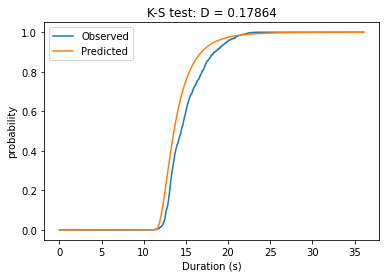

In [7]:
#mine
ks_mine = error_ks(t_test1, p_bayes1, t_op1, plot_graph = True)
print(ks_mine)
ks_mine = error_ks(t_test2, p_bayes2, t_op2, plot_graph = False)
print(ks_mine)

## 4b) KS test (2sample)

In [8]:
#library
ks_lib = sp.stats.ks_2samp(t_op1,t_op2)
print(ks_lib)

KstestResult(statistic=0.3073282070584051, pvalue=1.1102230246251565e-15)


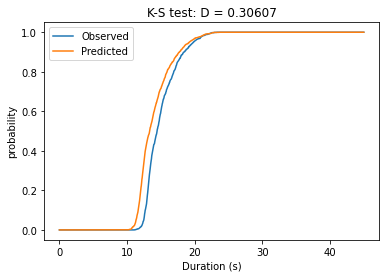

In [9]:
# mine
ks_mine = error_ks_2samples(t_op1, t_op2)

# 4c) CVM (one sample)

In [21]:
def cramervonmises(rvs, cdf, args=()):
    """Perform the one-sample Cramér-von Mises test for goodness of fit.
    This performs a test of the goodness of fit of a cumulative distribution
    function (cdf) :math:`F` compared to the empirical distribution function
    :math:`F_n` of observed random variates :math:`X_1, ..., X_n` that are
    assumed to be independent and identically distributed ([1]_).
    The null hypothesis is that the :math:`X_i` have cumulative distribution
    :math:`F`.
    Parameters
    ----------
    rvs : array_like
        A 1-D array of observed values of the random variables :math:`X_i`.
    cdf : str or callable
        The cumulative distribution function :math:`F` to test the
        observations against. If a string, it should be the name of a
        distribution in `scipy.stats`. If a callable, that callable is used
        to calculate the cdf: ``cdf(x, *args) -> float``.
    args : tuple, optional
        Distribution parameters. These are assumed to be known; see Notes.
    Returns
    -------
    res : object with attributes
        statistic : float
            Cramér-von Mises statistic.
        pvalue : float
            The p-value.

    """
    if isinstance(cdf, str):
        cdf = getattr(distributions, cdf).cdf

    vals = np.sort(np.asarray(rvs))

    if vals.size <= 1:
        raise ValueError('The sample must contain at least two observations.')
    if vals.ndim > 1:
        raise ValueError('The sample must be one-dimensional.')

    n = len(vals)
    cdfvals = cdf(vals, *args)

    u = (2*np.arange(1, n+1) - 1)/(2*n)
    w = 1/(12*n) + np.sum((u - cdfvals)**2)

    return w

In [22]:
#library
cvm_lib = cramervonmises(t_op2, 
                         lambda k: sp.stats.lognorm.cdf(
                             k, s = np.sqrt(var_map2), loc = offset2, scale = np.exp(mean_map2)
                         ))
print(cvm_lib)

48.466133714332614


27.41150061206013
48.432942651607235


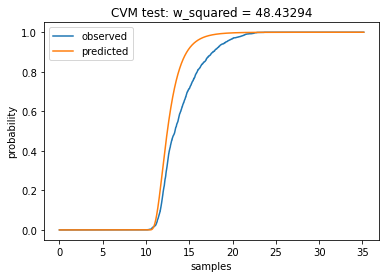

In [19]:
#mine
cvm_mine = error_cvm(t_test1, p_bayes1, t_op1, plot_graph = False)
print(cvm_mine)
cvm_mine = error_cvm(t_test2, p_bayes2, t_op2, plot_graph = True)
print(cvm_mine)

## 4d) Integrated area between CDFs

0.9115633739315844


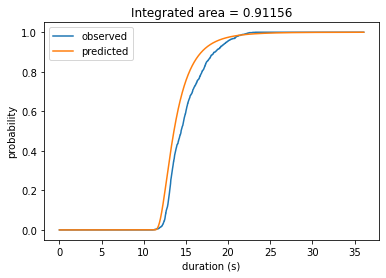

In [26]:
area = error_abs(t_test1, p_bayes1, t_op1, plot_graph = True)

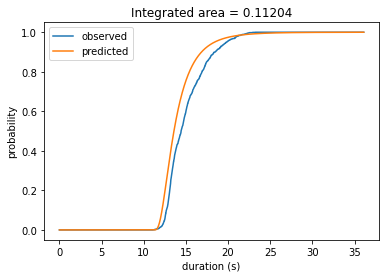

In [27]:
square_area = error_square(t_test1, p_bayes1, t_op1, plot_graph = True)